In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
import cv2

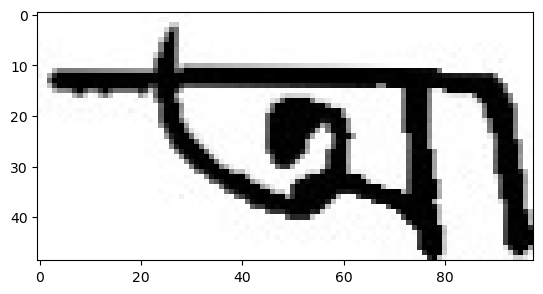

In [3]:
img = cv2.imread('/kaggle/input/ekush-final/Ekush/11/0_B.BARIA_17_2_363.jpg')
plt.imshow(img)

In [4]:
!pip install split_folders

In [5]:
import splitfolders
splitfolders.ratio("../input/ekush-final/Ekush", output="./", seed=1337, ratio=(.8, .1, .1), group_prefix=None)

Copying files: 364127 files [17:44, 342.01 files/s]


In [6]:
NUM_CLASSES = len(os.listdir(r'./test'))
print(NUM_CLASSES)

122


In [7]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, concatenate, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.metrics import Accuracy, Precision, Recall, AUC

In [8]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

train_generator=train_datagen.flow_from_directory(r'./train', # this is where you specify the path to the main data folder
                                                 target_size=(32,32),
                                                 color_mode='rgb',
                                                 batch_size=24,
                                                 class_mode='categorical',
                                                 shuffle=True)

val_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

val_generator=val_datagen.flow_from_directory(r'./val', # this is where you specify the path to the main data folder
                                                 target_size=(32,32),
                                                 color_mode='rgb',
                                                 batch_size=24,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 291173 images belonging to 122 classes.
Found 36363 images belonging to 122 classes.


In [9]:
import math

def plt_imshow_batch( batch_X, cols=8, cmap='gray' ):
    imgs = (batch_X.squeeze() * 255).astype('uint8')
    rows = math.ceil(len(imgs)/cols)
        
    fig, ax = plt.subplots(figsize=(20, rows*2))    
    plt.axis('off')        
    for index, img in enumerate(imgs):
        plt.subplot(rows, cols, index+1)
        plt.imshow(img, cmap=cmap) 

In [10]:
for image in train_generator:
  print(type(image))
  print(type(image[0]))
  print(image[0].shape)
  break

<class 'tuple'>
<class 'numpy.ndarray'>
(24, 32, 32, 3)


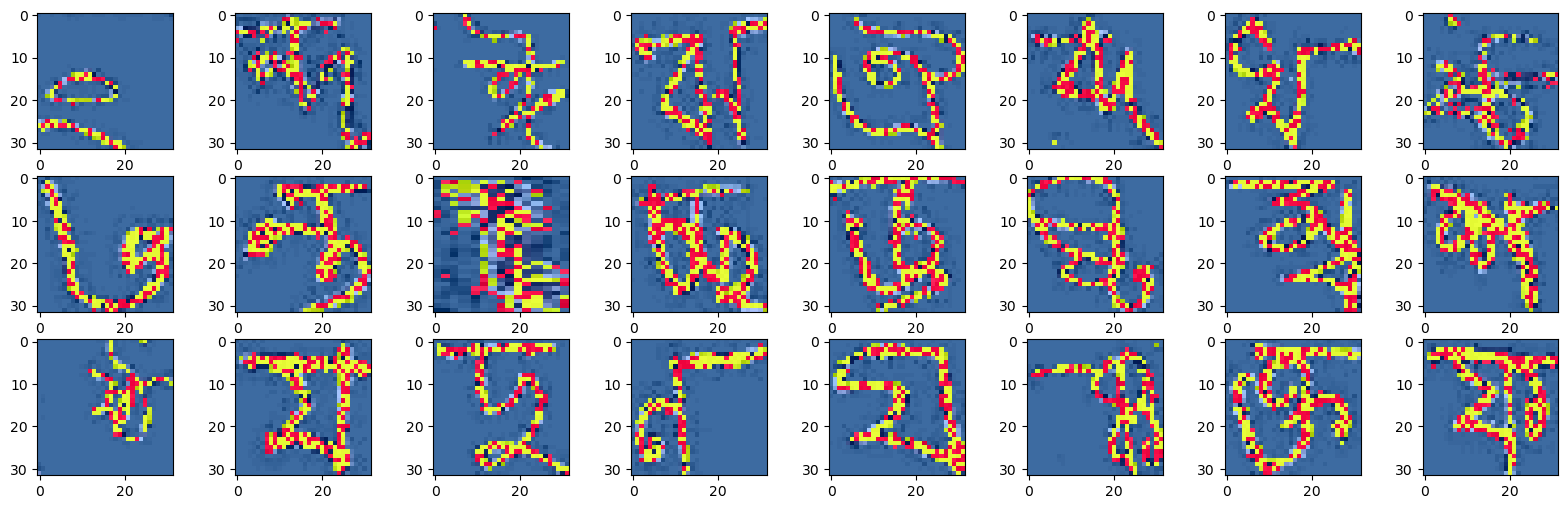

In [11]:
plt_imshow_batch(image[0])

In [12]:
model = Sequential()
input_layer = Input(shape=(32,32,3))

layer1 = VGG16(weights='imagenet', include_top=False, pooling='max', input_shape=(32, 32, 3)) (input_layer)
layer2 = DenseNet121(weights='imagenet', include_top=False, pooling='max', input_shape=(32, 32, 3)) (input_layer)

layer3 = concatenate([layer1, layer2])

layer4 = Dropout(0.5)(layer3)
layer5 = Dense(512, activation='relu', kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(layer4)
layer6 = Dropout(0.5)(layer5)
output_layer = Dense(NUM_CLASSES, activation='softmax', kernel_regularizer=l2(0.0001))(layer6)

model = Model(inputs=input_layer, outputs=output_layer)

29084464/29084464 [==============================] - 2s 0us/step


In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 vgg16 (Functional)             (None, 512)          14714688    ['input_1[0][0]']                
                                                                                                  
 densenet121 (Functional)       (None, 1024)         7037504     ['input_1[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 1536)         0           ['vgg16[0][0]',                  
                                                                  'densenet121[0][0]']        

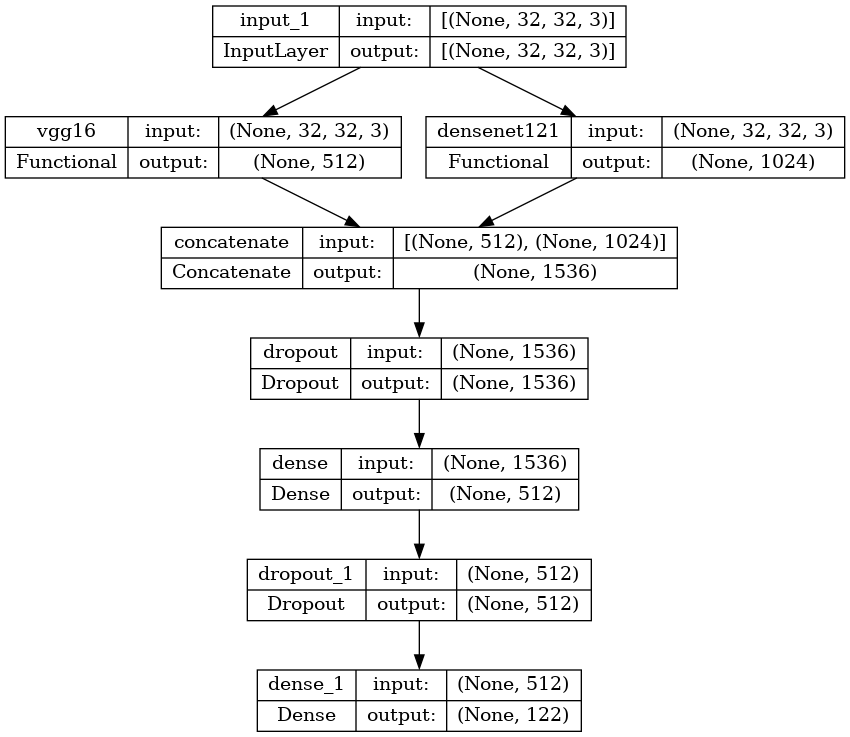

In [14]:
from keras.utils import plot_model
plot_model(model, to_file='Ekush Branching Transfer Learning.png', show_shapes=True)

In [15]:
earlystop=EarlyStopping(monitor='val_loss',patience=3) 
learning_rate_reduction=ReduceLROnPlateau(monitor='loss',patience=2,verbose=1,factor=0.1,min_lr=0.0000000001) 
callback=[learning_rate_reduction]

In [16]:
# metrics_ = [
#     'accuracy',
#     AUC(name='auc'),
#     Precision(name="precision"),
#     Recall(name="recall"), 
#            ]

In [17]:
model.compile(optimizer=Adam(learning_rate=0.001),
            loss=categorical_crossentropy, 
              metrics='accuracy')

In [18]:
step_size_train=train_generator.n//train_generator.batch_size
step_size_val=val_generator.n//val_generator.batch_size

history = model.fit(train_generator, 
                    steps_per_epoch=step_size_train, 
                    validation_data=val_generator, 
                    validation_steps=step_size_val, 
                    epochs=20,
                    callbacks=callback)

Epoch 1/20
12132/12132 [==============================] - 1197s 93ms/step - loss: 1.8475 - accuracy: 0.5466 - val_loss: 0.5968 - val_accuracy: 0.8798 - lr: 0.0010
Epoch 2/20
12132/12132 [==============================] - 1121s 92ms/step - loss: 0.7647 - accuracy: 0.8536 - val_loss: 0.5225 - val_accuracy: 0.9194 - lr: 0.0010
Epoch 3/20
12132/12132 [==============================] - 1112s 92ms/step - loss: 0.6170 - accuracy: 0.8971 - val_loss: 0.4799 - val_accuracy: 0.9293 - lr: 0.0010
Epoch 4/20
12132/12132 [==============================] - 1080s 89ms/step - loss: 0.5364 - accuracy: 0.9155 - val_loss: 0.4401 - val_accuracy: 0.9380 - lr: 0.0010
Epoch 5/20
12132/12132 [==============================] - 1066s 88ms/step - loss: 0.4834 - accuracy: 0.9260 - val_loss: 0.4041 - val_accuracy: 0.9432 - lr: 0.0010
Epoch 6/20
12132/12132 [==============================] - 1043s 86ms/step - loss: 0.4465 - accuracy: 0.9331 - val_loss: 0.3877 - val_accuracy: 0.9468 - lr: 0.0010
Epoch 7/20
12132/12132

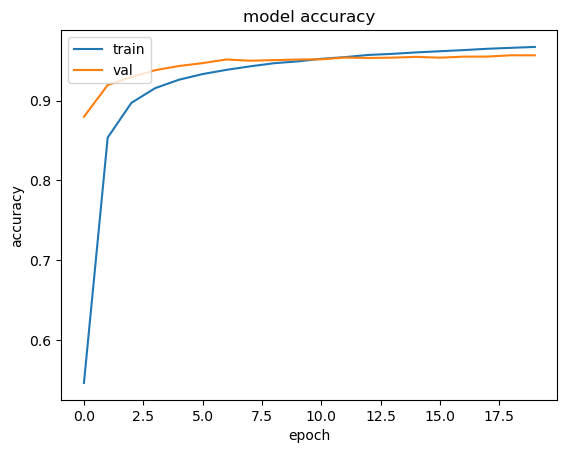

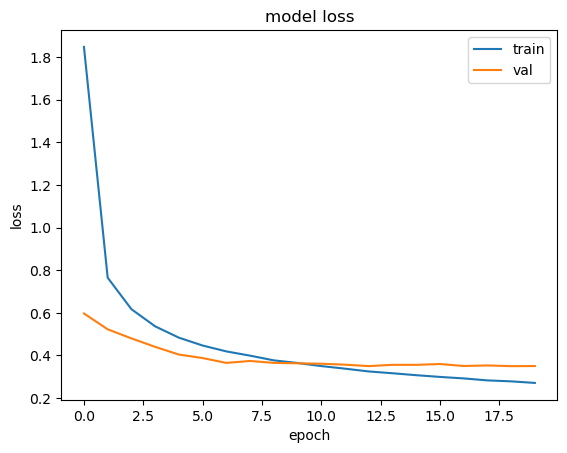

In [19]:
plt.figure(1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.figure(2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [20]:
test_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)
batch_size=24
pred_dir = r'./test'
test_generator = test_datagen.flow_from_directory(
    directory=pred_dir,
    target_size=(32,32),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

Found 36511 images belonging to 122 classes.


In [21]:
model.evaluate(val_generator, return_dict=True)

1516/1516 [==============================] - 38s 25ms/step - loss: 0.3502 - accuracy: 0.9566


{'loss': 0.350161075592041, 'accuracy': 0.9566042423248291}

In [22]:
pred=model.predict(test_generator,verbose=1,steps=test_generator.n/batch_size)

1521/1521 [==============================] - 41s 26ms/step


In [23]:
predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
print(results)

                       Filename Predictions
0          0/0_18_kis_2_361.jpg           0
1       0/0_B.BARI_13_1_368.jpg           0
2          0/0_BAR_14_1_407.jpg           0
3          0/0_BAR_15_1_418.jpg           0
4          0/0_BAR_15_1_420.jpg           0
...                         ...         ...
36506    99/1_SYL_11_1_1537.jpg          99
36507  99/1_Shar_20_3_00027.jpg          99
36508    99/1_TAN_11_1_1554.jpg          99
36509    99/1_TAN_11_1_1557.jpg          99
36510     99/1_TAN_1_1_1577.jpg          99

[36511 rows x 2 columns]


In [24]:
t_counter = 0
f_counter = 0

file_arr = []
pred_arr = []

for index, row in results.iterrows():
    #print(row['Filename'].split('/')[0], row['Predictions'])
    file_arr.append(row['Filename'].split('/')[0])
    pred_arr.append(row['Predictions'])
    if row['Filename'].split('/')[0] == row['Predictions']:
        t_counter = t_counter + 1
    else:
        f_counter = f_counter + 1
print(t_counter, f_counter)

35116 1395


In [25]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
labelencoder = LabelEncoder()
test_y = labelencoder.fit_transform(file_arr)
pred_y = labelencoder.fit_transform(pred_arr)
test_y_or = test_y
pred_y_or = pred_y

from keras.utils import np_utils
test_y = np_utils.to_categorical(test_y, NUM_CLASSES)
pred_y = np_utils.to_categorical(pred_y, NUM_CLASSES)
from sklearn.metrics import classification_report
print(classification_report(test_y, pred_y))

from sklearn.metrics import accuracy_score
score = accuracy_score(test_y, pred_y)
print(f"Test Accuracy: {score*100}")
print(confusion_matrix(test_generator.labels,np.argmax(pred,axis=1)))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       305
           1       1.00      0.98      0.99       310
           2       0.98      0.98      0.98       308
           3       0.99      0.95      0.97       306
           4       0.99      0.99      0.99       307
           5       0.98      0.98      0.98       308
           6       0.99      0.96      0.97       308
           7       0.96      0.92      0.94       308
           8       0.93      0.97      0.95       309
           9       0.99      0.98      0.98       305
          10       0.95      0.95      0.95       285
          11       0.97      1.00      0.99       306
          12       0.99      0.98      0.98       307
          13       0.98      0.99      0.98       309
          14       0.99      1.00      1.00       308
          15       0.97      0.99      0.98       307
          16       0.97      0.94      0.96       307
          17       0.94    

In [26]:
c=confusion_matrix(test_y.argmax(axis=1), pred_y.argmax(axis=1))
x = c.diagonal()/c.sum(axis=1)
for i in range(len(x)):
    print('Class ', i, ' Accuracy: ', x[i])

Class  0  Accuracy:  0.9934426229508196
Class  1  Accuracy:  0.9838709677419355
Class  2  Accuracy:  0.9772727272727273
Class  3  Accuracy:  0.9477124183006536
Class  4  Accuracy:  0.9869706840390879
Class  5  Accuracy:  0.9837662337662337
Class  6  Accuracy:  0.9577922077922078
Class  7  Accuracy:  0.9188311688311688
Class  8  Accuracy:  0.970873786407767
Class  9  Accuracy:  0.9770491803278688
Class  10  Accuracy:  0.9508771929824561
Class  11  Accuracy:  1.0
Class  12  Accuracy:  0.9804560260586319
Class  13  Accuracy:  0.9902912621359223
Class  14  Accuracy:  1.0
Class  15  Accuracy:  0.990228013029316
Class  16  Accuracy:  0.9413680781758957
Class  17  Accuracy:  0.9837662337662337
Class  18  Accuracy:  0.9902597402597403
Class  19  Accuracy:  0.9772727272727273
Class  20  Accuracy:  0.9739413680781759
Class  21  Accuracy:  0.9707792207792207
Class  22  Accuracy:  1.0
Class  23  Accuracy:  0.954248366013072
Class  24  Accuracy:  0.9838187702265372
Class  25  Accuracy:  0.888888888